# Data Attribute Recommendation - TechED 2020 INT260

Getting started with the Python SDK for the Data Attribute Recommendation service.

This workshop will cover:
    
* Data Upload
* Model Training and Deployment
* Inference Requests
    
We will work through a basic example of how to achieve these tasks using the [Python SDK for Data Attribute Recommendation](https://github.com/SAP/data-attribute-recommendation-python-sdk).

## Table of Contents

* [Exercise 01](#Exercise-01): Installing the SDK and preparing the service key
* [Exercise 02](#Exercise-02): Uploading the data
* [Exercise 03](#Exercise-03): Training the model
* [Exercise 04](#Exercise-04): Deploying the Model and predicting labels

## Requirements


See the [README in the Github repository for this workshop](https://github.com/SAP-samples/teched2020-INT260/blob/master/README.md#requirements).

# Exercise 01

*Back to [table of contents](#Table-of-Contents)*

In exercise 01, we will install the SDK and prepare the service key.

## Installing the SDK

The Data Attribute Recommendation SDK is available from the Python package repository. It can be installed with the standard `pip` tool:

In [ ]:
! pip install data-attribute-recommendation-sdk

### Outside of Jupyter Notebooks

If you are not using a Jupyter notebook, but instead a regular Python development environment, we recommend using a Python virtual environment to set up your development environment. Please see [the dedicated tutorial to learn how to install the SDK inside a Python virtual environment](https://developers.sap.com/tutorials/cp-aibus-dar-sdk-setup.html).

## Creating a service instance and key

Please log in to your trial account: https://cockpit.eu10.hana.ondemand.com/trial/

In the your global account screen, go to the "Boosters" tab:

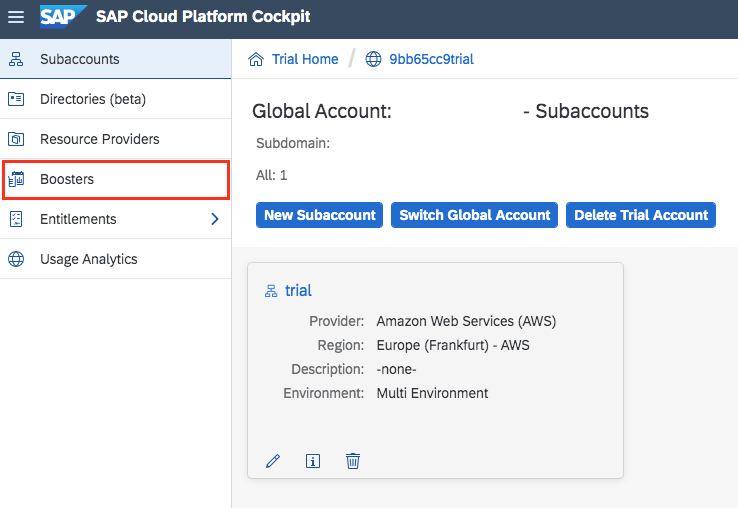



In the Boosters tab, enter "Data Attribute Recommendation" into the search box. Then, select the
service tile from the search results: 
    
![trial_locate_dar_booster.png](attachment:trial_locate_dar_booster.png)

The resulting screen shows details after the booster pack. Here, click the "Start" button and wait a few seconds.

![trial_start_booster.png](attachment:trial_start_booster.png)

Once the booster is finished, click the "go to Service Key" link to obtain your service key.

![trial_booster_finished.png](attachment:trial_booster_finished.png)

*If the booster fails, please follow this tutorial to manually [create a service instance and a service key](https://developers.sap.com/tutorials/cp-aibus-dar-service-instance.html)*

## Loading the service key into your Jupyter Notebook
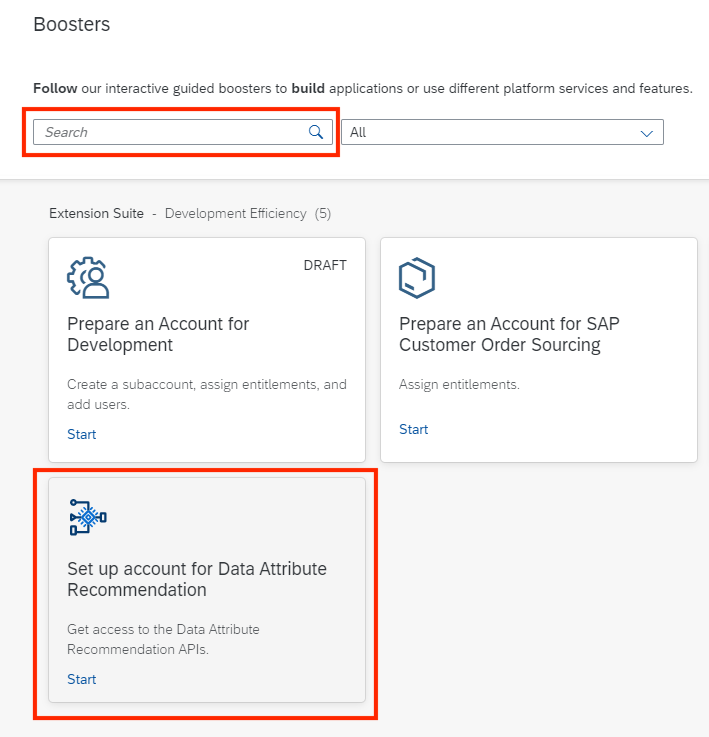

The resulting screen shows details after the booster pack. Here, click the "Start" button and wait a few seconds.

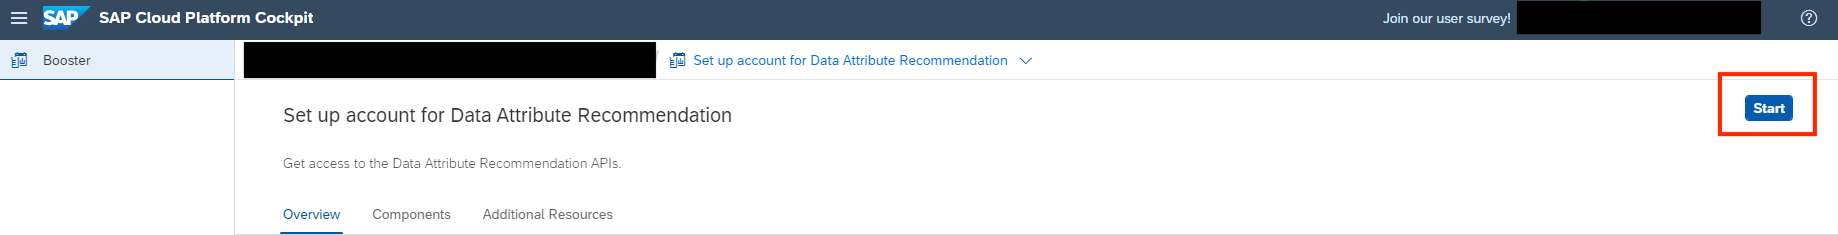

Once the booster is finished, click the "go to Service Key" link to obtain your service key.

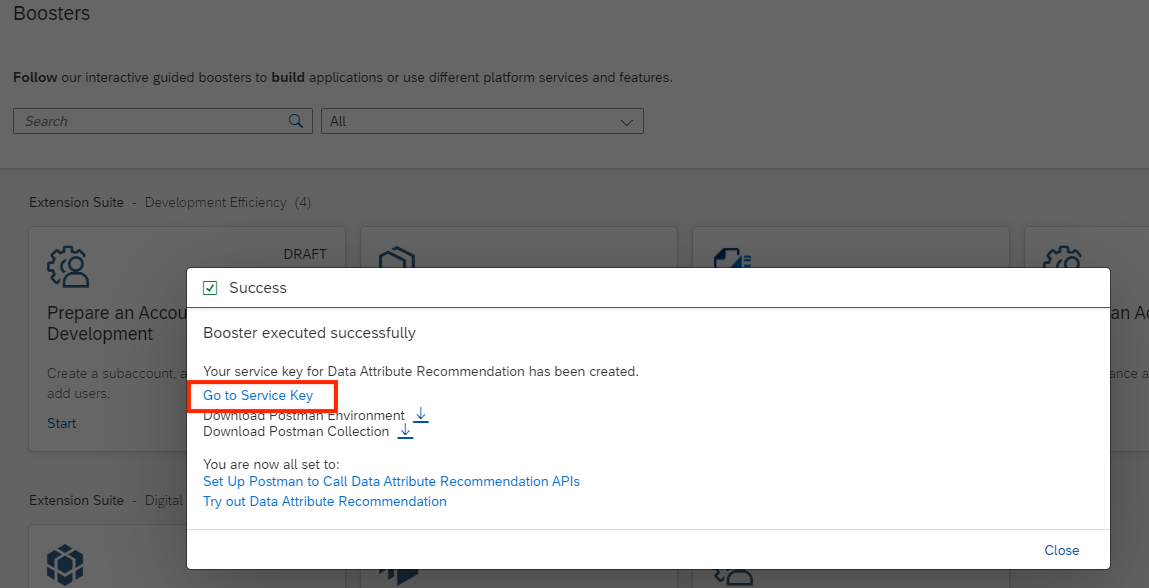

*If the booster fails, please follow this tutorial to manually [create a service instance and a service key](https://developers.sap.com/tutorials/cp-aibus-dar-service-instance.html)*

## Loading the service key into your Jupyter Notebook

Once you downloaded the service key from the Cockpit, upload it to your notebook environment.

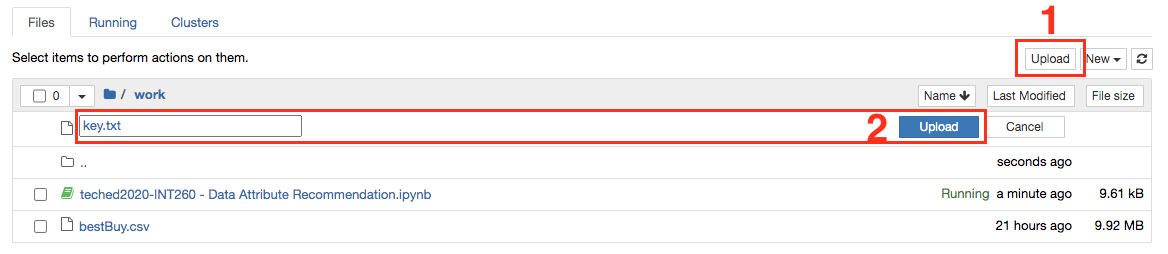

In the Jupyter file browser, click the **Upload** button (1). In the file selection dialog that opens, select the `key.txt` file you downloaded previously from the SAP Cloud Platform Cockpit. Confirm the upload by clicking on the second **Upload** button (2).

The service key contains your credentials to access the service. Please treat this as carefully as you would treat any password. We keep the service key as a separate file outside this notebook to avoid leaking the secret credentials.

The service key is a JSON file. We will load this file once and use the credentials throughout this workshop. 

In [ ]:
# First, set up logging so we can see the actions performed by the SDK behind the scenes
import logging
import sys

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

from pprint import pprint # for nicer output formatting

In [ ]:
import json
with open("key.txt") as file_handle:
    key = file_handle.read()
    SERVICE_KEY = json.loads(key)

With the service loaded and stored in the `SERVICE_KEY` variable, we can look inside:

In [ ]:
print(f"The service key has the following fields: {SERVICE_KEY.keys()}")
print()
print(f"Service URL: {SERVICE_KEY['url']}")
print()
print(f"Service API documentation:")
print(f"  Data Manager: {SERVICE_KEY['swagger']['dm']}")
print(f"  Model Manager: {SERVICE_KEY['swagger']['mm']}")
print(f"  Inference: {SERVICE_KEY['swagger']['inference']}")
print()
print("Authentication details:")
print(f"  Oauth URL: {SERVICE_KEY['uaa']['url']}")
print(f"  Oauth clientid: {SERVICE_KEY['uaa']['clientid']}")
# There is also a clientsecret key, which is the password. We do not print it here.

# Exercise 02

*Back to [table of contents](#Table-of-Contents)*
*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 02, we will upload our demo dataset to the service.

## The Dataset

### Obtaining the Data

The dataset we use in this workshop is a CSV file containing product master data. The original data was released by BestBuy, a retail company, under an [open license](https://github.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample#data-and-license). This makes it ideal for first experiments with the Data Attribute Recommendation service.

The dataset can be downloaded directly from Github using the following command:

In [ ]:
! wget -O bestBuy.csv "https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv"
# If you receive a "command not found" error (i.e. on Windows), try curl instead of wget:
# ! curl -o bestBuy.csv "https://raw.githubusercontent.com/SAP-samples/data-attribute-recommendation-postman-tutorial-sample/master/Tutorial_Example_Dataset.csv"

Let's inspect the data:

In [ ]:
# if you are experiencing an import error here, run the following in a new cell:
# ! pip install pandas
import pandas as pd

df1 = pd.read_csv("bestBuy.csv")
df1.head(5)

In [ ]:
df1.shape

The CSV contains the several products. For each product, the description, the manufacturer and the price are given. Additionally, three levels of the products hierarchy are given.

The first product, a set of AAA batteries, is located in the following place in the product hierarchy:

```
level1_category:         Connected Home & Housewares
                                      |
level2_category:                  Housewares
                                      |
level3_category:              Household Batteries
```

We will use the Data Attribute Recommendation service to predict the categories for a given product based on its **description**, **manufacturer** and **price**.

### Creating the DatasetSchema

We first have to describe the shape of our data by creating a DatasetSchema. This schema informs the service about the individual column types found in the CSV. We also describe which are the target columns used for training. These columns will be later predicted. In our case, these are the three category columns.

The service currently supports three column types: **text**, **category** and **number**. For prediction, only **category** is currently supported.

A DatasetSchema for the BestBuy dataset looks as follows:

```json
{
    "features": [
        {"label": "manufacturer", "type": "CATEGORY"},
        {"label": "description", "type": "TEXT"},
        {"label": "price", "type": "NUMBER"}
    ],
    "labels": [
        {"label": "level1_category", "type": "CATEGORY"},
        {"label": "level2_category", "type": "CATEGORY"},
        {"label": "level3_category", "type": "CATEGORY"}
    ],
    "name": "bestbuy-category-prediction",
}
```

We will now upload this DatasetSchema to the Data Attribute Recommendation service. The SDK provides the
[DataManagerClient.create_dataset_schema()](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.create_dataset_schema) method for this purpose.


In [ ]:
from sap.aibus.dar.client.data_manager_client import DataManagerClient

dataset_schema = {
    "features": [
        {"label": "manufacturer", "type": "CATEGORY"},
        {"label": "description", "type": "TEXT"},
        {"label": "price", "type": "NUMBER"}
    ],
    "labels": [
        {"label": "level1_category", "type": "CATEGORY"},
        {"label": "level2_category", "type": "CATEGORY"},
        {"label": "level3_category", "type": "CATEGORY"}
    ],
    "name": "bestbuy-category-prediction",
}


data_manager = DataManagerClient.construct_from_service_key(SERVICE_KEY)
response = data_manager.create_dataset_schema(dataset_schema)
dataset_schema_id = response["id"]

print()
print("DatasetSchema created:")

pprint(response)

print()
print("DatasetSchema ID: %s" % dataset_schema_id)

The API responds with the newly created DatasetSchema object. The service assigned an ID to the schema. We save this ID in a variable, as we will need it when we upload the data.

#### Advanced Exercise

Create a new cell. Use the [`DataManagerClient.read_dataset_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.delete_dataset_schema_by_id) and the [`DataManagerClient.read_dataset_schema_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_schema_collection) methods to list the newly created and all DatasetSchemas, respectively.

### Uploading the Data to the service

The [`DataManagerClient`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient) class is also responsible for uploading data to the service. This data must fit to an existing DatasetSchema. After uploading the data, the service will validate the Dataset against the DataSetSchema in a background process.

We will now upload our `bestBuy.csv` file, using the DatasetSchema which we created earlier.

Data upload is a two-step process. We first create the Dataset using [`DataManagerClient.create_dataset()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.create_dataset). Then we can upload data to the Dataset using the [`DataManagerClient.upload_data_to_dataset()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.upload_data_to_dataset) method.

In [ ]:
dataset_resource = data_manager.create_dataset("my-bestbuy-dataset", dataset_schema_id)
dataset_id = dataset_resource["id"]

print()
print("Dataset created:")

pprint(dataset_resource)

print()
print("Dataset ID: %s" % dataset_id)

In [ ]:
with open('bestBuy.csv', 'rb') as file_handle:
    # Open in binary mode. Maybe fix https://github.com/SAP/data-attribute-recommendation-python-sdk/issues/78
    # before TechED
    dataset_resource = data_manager.upload_data_to_dataset(dataset_id, file_handle)

print()
print("Dataset after data upload:")
print()
pprint(dataset_resource)

Note that the Dataset status changed from `NO_DATA` to `VALIDATING`.

Dataset validation is a background process. The status will eventually change from `VALIDATING` to `SUCCEEDED`.
The SDK provides the [`DataManagerClient.wait_for_dataset_validation()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.wait_for_dataset_validation) method to poll for the Dataset validation.

In [ ]:
dataset_resource = data_manager.wait_for_dataset_validation(dataset_id)

print()
print("Dataset after validation has finished:")

print()
pprint(dataset_resource)

If the status is `FAILED` instead of `SUCCEEDED`, then the `validationMessage` will contain details about the validation failure.

#### Advanced Exercise

Create a new cell and use the [`DataManagerClient.read_dataset_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_by_id) and the [`DataManagerClient.read_dataset_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.read_dataset_collection) methods to inspect the newly created dataset.


Instead of using two separate methods to upload data and wait for validation to finish, you can also use [`DataManagerClient.upload_data_and_validate()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.data_manager_client.DataManagerClient.upload_data_and_validate).

# Exercise 03

*Back to [table of contents](#Table-of-Contents)*

*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 03, we will train the model.

## Training the Model

The Dataset is now uploaded and has been validated successfully by the service.

To train a machine learning model, we first need to select the correct model template.

### Selecting the right ModelTemplate

The Data Attribute Recommendation service currently supports two different ModelTemplates:

| ID                                   | Name                  | Description                                                               |
|--------------------------------------|---------------------------|---------------------------------------------------------------------------|
| d7810207-ca31-4d4d-9b5a-841a644fd81f | **Hierarchical template** | Recommended for the prediction of multiple classes that form a hierarchy. |
| 223abe0f-3b52-446f-9273-f3ca39619d2c | **Generic template**      | Generic neural network for multi-label, multi-class classification.       |

We are building a model to predict product hierarchies. The **Hierarchical Template** is correct for this scenario. In this template, the first label in the DatasetSchema is considered the top-level category. Each subsequent label is considered to be further down in the hierarchy. 

Coming back to our example DatasetSchema:

```json
{
 "labels": [
        {"label": "level1_category", "type": "CATEGORY"},
        {"label": "level2_category", "type": "CATEGORY"},
        {"label": "level3_category", "type": "CATEGORY"}
    ]
}
```

The first defined label is `level1_category`, which is considered more important than `level3_category`.

## Starting the training

When working with models, we use the [`ModelManagerClient`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient) class.

To start the training, we need the IDs of the dataset and the desired model template. We also have to provide a name for the model.
The [`ModelManagerClient.create_job()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.create_job) method launches the training Job.

In [ ]:
from sap.aibus.dar.client.model_manager_client import ModelManagerClient


model_manager = ModelManagerClient.construct_from_service_key(SERVICE_KEY)

model_template_id = "d7810207-ca31-4d4d-9b5a-841a644fd81f" # hierarchical template

model_name = "bestbuy-hierarchy-model" # we will need this later

# If this is not the first name running this cell, either change the model_name above
# or delete the existing model. Note that deployed models cannot be deleted without
# undeploying them
# model_manager.delete_model_by_name(model_name)

# TODO: Implement https://github.com/SAP/data-attribute-recommendation-python-sdk/issues/79
#all_jobs = model_manager.read_job_collection()

# for job in all_jobs["jobs"]:
#     if job["modelName"] == model_name:
#         model_manager.delete_job_by_id(job["id"])


job_resource = model_manager.create_job(model_name, dataset_id, model_template_id)
job_id = job_resource['id']

print()
print("Job resource:")
print()

pprint(job_resource)

print()
print(f"ID of submitted Job: {job_id}")

The job is now running in the background. Similar to the DatasetValidation, we have to poll the job until it succeeds.
The SDK provides the [`ModelManagerClient.wait_for_job()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_job) method:

In [ ]:
job_resource = model_manager.wait_for_job(job_id)

print()

print("Job resource after training is finished:")

pprint(job_resource)

#### Advanced Exercise

Create a new cell and use the [`ModelManagerClient.read_model_template_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_model_template_collection) to list all existing model templates.

Use [`ModelManagerClient.read_job_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_job_by_id) and [`ModelManagerClient.read_job_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_job_collection) to inspect the job we just created.

The entire process of uploading the data and starting the training is also available as a single method call in [`ModelCreator.create()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.workflow.model.ModelCreator.create).

## Intermission

The model training will take between 5 and 10 minutes.

In the meantime, we can explore the available [resources](#Resources) for both the service and the SDK.

# Exercise 04

*Back to [table of contents](#Table-of-Contents)*

*To perform this exercise, you need to execute the code in all previous exercises.*

In exercise 04, we will deploy the model and predict labels for some unlabeled data.

## Deploying the Model

The training job has finished and the model is ready to be deployed. By deploying the model, we create a server process in the background which will process inference requests.

In the SDK, the [`ModelManagerClient.create_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#module-sap.aibus.dar.client.model_manager_client) method lets use create a Deployment.


In [ ]:
deployment_resource =  model_manager.create_deployment(model_name)
deployment_id = deployment_resource["id"]

print()
print("Deployment resource:")
print()

pprint(deployment_resource)

print("Deployment ID: %s" % deployment_id)

Similar to the data upload and the training job, model deployment is an asynchronous process. We have to poll the API until the Deployment is in status `SUCCEEDED`. The SDK provides the [`ModelManagerClient.wait_for_deployment()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.wait_for_deployment) for this purposes.

In [ ]:
deployment_resource = model_manager.wait_for_deployment(deployment_id)

print()
print("Finished deployment resource:")
print()

pprint(deployment_resource)

Once the Deployment is in status `SUCCEEDED`, we can run inference requests.

#### Advanced Exercise

Create a new cell and use [`ModelManagerClient.read_deployment_by_id()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_by_id) and [`ModelManagerClient.read_deployment_collection()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.read_deployment_collection) to inspect the Deployment.

Use the [`ModelManagerclient.lookup_deployment_id_by_model_name()`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.model_manager_client.ModelManagerClient.lookup_deployment_id_by_model_name) method to find the deployment ID for a given model name.

For trial users: the deployment will be stopped after 8 hours. You can restart it by deleting the deployment and creating a new one for your model. The [`ModelManagerClient.ensure_deployment_exists()`](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html) method will delete and re-create automatically. Then, you need to poll until the deployment is succeeded using `wait_for_deployment` as above.

## Executing Inference requests

With an inference requests, we can send up to 50 objects to the service to predict the labels. The data send to the service must match the `features` section of the DatasetSchema created earlier. The `labels` defined inside of the DatasetSchema will be predicted for each object and returned as a response to the request.

In the SDK, the [InferenceClient.create_inference_request](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.inference_client.InferenceClient.create_inference_request) method handles submission of inference requests.

In [ ]:
from sap.aibus.dar.client.inference_client import InferenceClient

inference = InferenceClient.construct_from_service_key(SERVICE_KEY)

objects_to_be_classified = [
    {
        "objectId": "optional-identifier-1",
        "features": [
            {"name": "manufacturer", "value": "Energizer"},
            {"name": "description", "value": "Alkaline batteries; 1.5V"},
            {"name": "price", "value":  "5.99"},
        ],
    },
    {
        "objectId": "optional-identifier-2",
        "features": [
            {"name": "manufacturer", "value": "Eidos"},
            {"name": "description", "value": "Unravel a grim conspiracy at the brink of Revolution"},
            {"name": "price", "value":  "19.99"},
        ],
    },
]


inference_response = inference.create_inference_request(model_name, objects_to_be_classified)

print()
print("Inference request processed. Response:")
pprint(inference_response)


#### Advanced Exercise

Use the [`InferenceClient.do_bulk_inference`](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/api.html#sap.aibus.dar.client.inference_client.InferenceClient.do_bulk_inference) method to process more than fifty objects at a time. Note how the data format returned changes.

Note: for trial accounts, you only have a limited number of objects which you can classify.

## Cleanup

During the course of the workshop, we have created several resources on the Data Attribute Recommendation Service:

* DatasetSchema
* Dataset
* Job
* Model
* Deployment

The SDK provides several methods to delete these resources. Note that there are dependencies between objects: you cannot delete a Dataset without deleting the Model beforehand.

In [ ]:
# Clean up all resources created earlier

model_manager.delete_deployment_by_id(deployment_id) # this can take a few seconds
model_manager.delete_model_by_name(model_name)
model_manager.delete_job_by_id(job_id)

data_manager.delete_dataset_by_id(dataset_id)
data_manager.delete_dataset_schema_by_id(dataset_schema_id)

# Summary

In this workshop, we looked into the following topics:

* Installation of the Python SDK for Data Attribute Recommendation
* Modeling data with a DatasetSchema
* Uploading data into a Dataset
* Training a model
* Predicting labels for unlabelled data

Feel free to revisit the workshop materials at any time. The [resources](#Resources) section below contains additional reading.

## Resources

### SDK Resources

* [SDK source code on Github](https://github.com/SAP/data-attribute-recommendation-python-sdk)
* [SDK documentation](https://data-attribute-recommendation-python-sdk.readthedocs.io/en/latest/)
* [How to obtain support](https://github.com/SAP/data-attribute-recommendation-python-sdk/blob/master/README.md#how-to-obtain-support)
* Tutorials: [Classify Data Records with the SDK for Data Attribute Recommendation](https://developers.sap.com/group.cp-aibus-data-attribute-sdk.html)

### Data Attribute Recommendation

* [SAP Help Portal](https://help.sap.com/viewer/product/Data_Attribute_Recommendation/SHIP/en-US)
* [API Reference](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/b45cf9b24fd042d082c16191aa938c8d.html)
* [Trial Account Limits](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/c03b561eea1744c9b9892b416037b99a.html)
* [Metering and Pricing](https://help.sap.com/viewer/105bcfd88921418e8c29b24a7a402ec3/SHIP/en-US/1e093326a2764c298759fcb92c5b0500.html)
* [Tutorials](https://developers.sap.com/mission.cp-aibus-data-attribute.html)
